In [119]:
#import libs
import matplotlib.pyplot as plt

import plotly as py
import plotly.express as px

import seaborn as sns

import pandas as pd
import numpy as np

import sklearn
from sklearn import linear_model
from sklearn.utils import shuffle

# Introduction

## Define the Problem ...
 
Task of competition is to predict using ML whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. 

Training data has been provided in the file train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

Testing data has been provided in the file test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. 

Task is to predict the value of Transported for the passengers in the test dataset.

## Define the type of Problem ...

Given that we need to predict the total value of passengers transported, the output will be a category or label (i.e. transported (True) or not transported (False). Therefore, this is a classification type of problem to solve. 

Next steps ...
1. Binary classification, as there are only two possible outcomes, True or False
2. Are there any relationships between variables? Is there a decision boundary that seperates different classes? 
3. Evaluation metrics for classification include:- 
* accuracy
* precision
* recall
* F1-score 


In [172]:
#Gather and prepare training data (data is already split between training and test data)

#file_path = "/kaggle/input/spaceship-titanic/train.csv"
file_path = r"C:\Users\Krupa\Documents\Krups Coding\Kaggle\ML_titanic\train.csv"
train_data = pd.read_csv(file_path)
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [121]:
train_data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [122]:
train_data.shape

(8693, 14)

In [123]:
#generate descriptive statistics
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


The max. figures for Room Service, Food Court, Shopping Mall, Spa and VR Deck are all total amounts of money spent in these areas and are in the thousands. Whereas, the max. age is 79 and that seems reasonable. Another point to note is that none of the Amenities have a meadian value (i.e. 50th percentile).


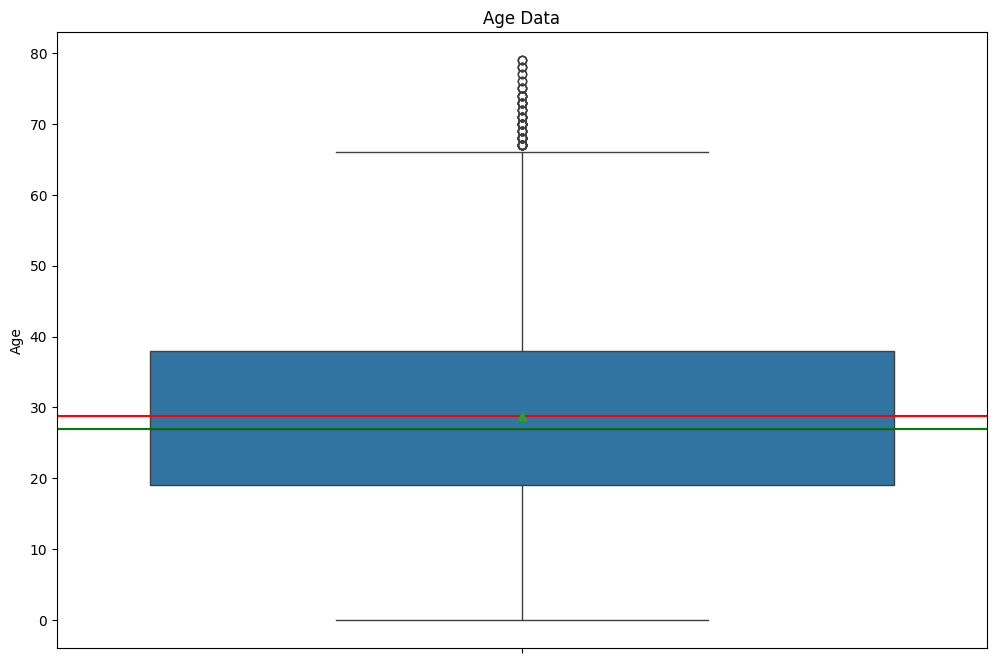

In [124]:
#Let's take a closer look at the spread of the age data 
plt.figure(figsize = (12,8))

sns.boxplot(data=train_data, y ='Age', showmeans=True)

mean_age=train_data['Age'].mean()
median_age=train_data['Age'].median()
plt.axhline(y=mean_age, color='r', linestyle='-')
plt.axhline(y=median_age, color='g', linestyle='-')

plt.title('Age Data')

plt.show()

In [125]:
train_data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [126]:
#Clean and pre-process data 
#check and handle missing values, outliers etc. 

print('missing values (%) per column: \n', 100*train_data.isnull().mean())

missing values (%) per column: 
 PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64


In [173]:
#overall percentage of missing values 
total_cells = np.product(train_data.shape)
missing_vals = train_data.isnull().sum()
total_missing_vals = missing_vals.sum()
percent_missing_vals = ((total_missing_vals/total_cells)*100).round(2)
print('Overall percentage of missing values in dataset: ', percent_missing_vals,'%')


Overall percentage of missing values in dataset:  1.91 %


There is a small percentage of missing values in 12 out of 14 of the columns. The only columns without missing data are PassengerId and Transported.

For the numerical columns we could impute the mean value:-
* Age
* RoomService
* FoodCourt
* ShoppingMall
* Spa
* VRDeck


In [174]:
#Let's fill the missing numerical values with mean values

mean_age=train_data['Age'].mean()
mean_RS=train_data['RoomService'].mean()
mean_FC=train_data['FoodCourt'].mean()
mean_SM=train_data['ShoppingMall'].mean()
mean_Spa=train_data['Spa'].mean()
mean_VRDeck=train_data['VRDeck'].mean()


train_data['Age'].fillna(mean_age, inplace=True)
train_data['RoomService'].fillna(mean_RS, inplace=True)
train_data['FoodCourt'].fillna(mean_FC, inplace=True)
train_data['ShoppingMall'].fillna(mean_SM, inplace=True)
train_data['Spa'].fillna(mean_Spa, inplace=True)
train_data['VRDeck'].fillna(mean_VRDeck, inplace=True)

In [175]:
total_cells = np.product(train_data.shape)
missing_vals = train_data.isnull().sum()
total_missing_vals = missing_vals.sum()
updated_percent_missing_vals = ((total_missing_vals/total_cells)*100).round(2)


print('Percentage of missing values following mean value update',updated_percent_missing_vals , '%')

Percentage of missing values following mean value update 0.99 %


Now we are down to **less than 1%** of missing values in the remaining columns! Let's take a look at the categorical data:-

* HomePlanet
* CryoSleep
* Cabin
* Destination
* VIP
* Name 



In [176]:
#how many values are missing in the category columns?

missing_hp_val=train_data['HomePlanet'].isnull().sum()
missing_cs_val=train_data['CryoSleep'].isnull().sum()
missing_cab_val=train_data['Cabin'].isnull().sum()
missing_dest_val=train_data['Destination'].isnull().sum()
missing_vip_val=train_data['VIP'].isnull().sum()
missing_name_val=train_data['Name'].isnull().sum()

print('Missing Home Planet Values:', missing_hp_val)
print('Missing CryoSleep Values:', missing_cs_val)
print('Missing Cabin Values:', missing_cab_val)
print('Missing Destination Values:', missing_dest_val)
print('Missing VIP Values:', missing_vip_val)
print('Missing Name Values:', missing_name_val)



Missing Home Planet Values: 201
Missing CryoSleep Values: 217
Missing Cabin Values: 199
Missing Destination Values: 182
Missing VIP Values: 203
Missing Name Values: 200


The missing values in the category column seem to hover around the 200-mark. Let's determine the mode value for each of the categorical data columns.


In [177]:
#mode method returns the most frequently occurring value and iloc[o] returns the first from a series
mode_hp=train_data['HomePlanet'].mode().iloc[0]
mode_cs=train_data['CryoSleep'].mode().iloc[0]
mode_cab=train_data['Cabin'].mode().iloc[0]
mode_dest=train_data['Destination'].mode().iloc[0]
mode_vip=train_data['VIP'].mode().iloc[0]
mode_name=train_data['Name'].mode().iloc[0]


print('Mode Home Planet Value:', mode_hp)
print('Mode CryoSleep Value:', mode_cs)
print('Mode Cabin Value:', mode_cab)
print('Mode Destination Value:', mode_dest)
print('Mode VIP Value:', mode_vip)
print('Mode Name Value:', mode_name)


Mode Home Planet Value: Earth
Mode CryoSleep Value: False
Mode Cabin Value: G/734/S
Mode Destination Value: TRAPPIST-1e
Mode VIP Value: False
Mode Name Value: Alraium Disivering


In [178]:
#Let's first fill the home planet values and destination values with the mode
train_data['HomePlanet'].fillna(mode_hp, inplace=True)
train_data['CryoSleep'].fillna(mode_cs, inplace=True)
train_data['Cabin'].fillna(mode_cab, inplace=True)
train_data['Destination'].fillna(mode_dest, inplace=True)
train_data['VIP'].fillna(mode_vip, inplace=True)
train_data['Name'].fillna(mode_name, inplace=True)


In [179]:
train_data.shape

(8693, 14)

In [180]:
total_cells = np.product(train_data.shape)
missing_vals = train_data.isnull().sum()
total_missing_vals = missing_vals.sum()
second_updated_percent_missing_vals = ((total_missing_vals/total_cells)*100).round(2)

print('Percentage of missing values following mode update',second_updated_percent_missing_vals , '%')

Percentage of missing values following mode update 0.0 %


In [181]:
print('missing values (%) per column: \n', 100*train_data.isnull().mean())

missing values (%) per column: 
 PassengerId     0.0
HomePlanet      0.0
CryoSleep       0.0
Cabin           0.0
Destination     0.0
Age             0.0
VIP             0.0
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
Name            0.0
Transported     0.0
dtype: float64


Now the missing values have been dealt with, we can move on to the next step, data analysis,

# Data Analysis

In [182]:
#For better readability and data analysis let's split the cabin column into three separate columns for deck, number and side.

train_data[['Cabin Deck', 'Cabin Number', 'Cabin Side']] = train_data['Cabin'].str.split('/', expand=True)


In [183]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin Deck,Cabin Number,Cabin Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


In [138]:
#let's take a closer look at cryo sleep and transported stats 

fig = px.histogram(train_data, x='CryoSleep', title = "CryoSleep Request Histogram", color= train_data['Transported'])
fig.show()

In [139]:
#let's take a closer look at home planet and transported stats 

fig = px.histogram(train_data, x='HomePlanet', title = "Home Planet Histogram", color= train_data['Transported'])
fig.show()

In [140]:
#let's take a closer look at cabin side and transported stats 

fig = px.histogram(train_data, x='Cabin Side', title = "Cabin Side (Port or Starboard) Histogram", color= train_data['Transported'])
fig.show()

In [141]:
#let's take a closer look at deck level and transported stats 

fig = px.histogram(train_data, x='Cabin Deck', title = "Cabin Deck Histogram", color= train_data['Transported'])
fig.show()

In [142]:
#let's take a closer look at passenger age and transported stats 

fig = px.histogram(train_data, x='Age', title = "Passenger Age Histogram", color= train_data['Transported'])
fig.show()

In [143]:
#let's take a closer look at VIP and transported stats 

fig = px.histogram(train_data, x='VIP', title = "VIP Service Histogram", color= train_data['Transported'])
fig.show()

In [144]:
#let's take a closer look at Destination and transported stats 

fig = px.histogram(train_data, x='Destination', title = "Destination Histogram", color= train_data['Transported'])
fig.show()

From the graphs above, it is evident that the strongest correlation is between cryo sleep  and being transported. Also, a high proportion of passengers located on decks B, C and G were transported. Let's also plot a correlation graph to identify any other patterns. For ease, it could be useful to map categorical data values to integers. 


In [184]:
#map data in Home Planet, Destination and Cabin Deck columns 
mapping_dict1 = {'Earth':1, 'Europa':2, 'Mars':3}
train_data['HomePlanet'] = train_data['HomePlanet'].map(mapping_dict1)

mapping_dict2 = {'P':1, 'S':2}
train_data['Cabin Side'] = train_data['Cabin Side'].map(mapping_dict2)

mapping_dict3 = {'TRAPPIST-1e': 1, 'PSO J318.5-22': 2, '55 Cancri e': 3}
train_data['Destination'] = train_data['Destination'].map(mapping_dict3)

mapping_dict4 = {'A': 1, 'B': 2, 'C': 3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8}
train_data['Cabin Deck'] = train_data['Cabin Deck'].map(mapping_dict4)

In [185]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin Deck,Cabin Number,Cabin Side
0,0001_01,2,False,B/0/P,1,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,2,0,1
1,0002_01,1,False,F/0/S,1,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,6,0,2
2,0003_01,2,False,A/0/S,1,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1,0,2
3,0003_02,2,False,A/0/S,1,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1,0,2
4,0004_01,1,False,F/1/S,1,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,6,1,2


In [147]:
#let's drop some columns for the correlation graph
reduced_train_data=train_data.drop(columns=['PassengerId', 'Name', 'Cabin', 'Cabin Number'])
reduced_train_data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin Deck,Cabin Side
0,2,False,1,39.0,False,0.0,0.0,0.0,0.0,0.0,False,2,1
1,1,False,1,24.0,False,109.0,9.0,25.0,549.0,44.0,True,6,2
2,2,False,1,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,1,2
3,2,False,1,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,1,2
4,1,False,1,16.0,False,303.0,70.0,151.0,565.0,2.0,True,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,2,False,3,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,1,1
8689,1,True,2,18.0,False,0.0,0.0,0.0,0.0,0.0,False,7,2
8690,1,False,1,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,7,2
8691,2,False,3,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,5,2


In [148]:
reduced_train_data.dtypes

HomePlanet        int64
CryoSleep          bool
Destination       int64
Age             float64
VIP                bool
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported        bool
Cabin Deck        int64
Cabin Side        int64
dtype: object

In [149]:
reduced_train_data.describe(exclude='number')

,CryoSleep,VIP,Transported
count,8693,8693,8693
unique,2,2,2
top,False,False,True
freq,5656,8494,4378


In [150]:
reduced_train_data.corr().style.background_gradient(cmap='Oranges')

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin Deck,Cabin Side
HomePlanet,1.000000,0.083586,-0.034737,0.133888,0.123512,0.211527,0.071642,0.101056,0.055014,0.039575,0.115461,-0.404593,0.000636
CryoSleep,0.083586,1.000000,0.096287,-0.070736,-0.078281,-0.243986,-0.205682,-0.206366,-0.198392,-0.193107,0.460132,0.020613,0.023858
Destination,-0.034737,0.096287,1.000000,0.006619,0.044707,-0.046390,0.111049,-0.024384,0.055916,0.073233,0.108152,-0.180763,0.012979
Age,0.133888,-0.070736,0.006619,1.000000,0.091574,0.067612,0.127937,0.032655,0.120992,0.099210,-0.074249,-0.239353,0.011758
VIP,0.123512,-0.078281,0.044707,0.091574,1.000000,0.056595,0.126006,0.018483,0.060573,0.123092,-0.037261,-0.176063,-0.008798
RoomService,0.211527,-0.243986,-0.046390,0.067612,0.056595,1.000000,-0.015521,0.052962,0.009925,-0.019207,-0.242048,-0.021148,-0.007503
FoodCourt,0.071642,-0.205682,0.111049,0.127937,0.126006,-0.015521,1.000000,-0.013934,0.220587,0.224275,0.046074,-0.315326,0.019602
ShoppingMall,0.101056,-0.206366,-0.024384,0.032655,0.018483,0.052962,-0.013934,1.000000,0.013678,-0.007189,0.010019,-0.033470,-0.021922
Spa,0.055014,-0.198392,0.055916,0.120992,0.060573,0.009925,0.220587,0.013678,1.000000,0.147957,-0.218791,-0.214997,0.005739
VRDeck,0.039575,-0.193107,0.073233,0.099210,0.123092,-0.019207,0.224275,-0.007189,0.147957,1.000000,-0.204825,-0.251021,-0.008975


r-values greater than 0.7 indicate a strong correlation between two attributes. From the graph above, there doesn't appear to be any strong correlations. However, the graph does confirms what was found in the data analysis, CryoSleep and Transported are highly correlated, with an r-value of 0.46

In [186]:
train_data.shape

(8693, 17)

In [187]:
train_data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'Cabin Deck', 'Cabin Number', 'Cabin Side'],
      dtype='object')

In [188]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   int64  
 2   CryoSleep     8693 non-null   bool   
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   int64  
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   bool   
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
 14  Cabin Deck    8693 non-null   int64  
 15  Cabin Number  8693 non-null   object 
 16  Cabin Side    8693 non-null   int64  
dtypes: bool(3), float64(6), int64(4), object(4)
memory usage: 976.4+ KB


In [189]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin Deck,Cabin Number,Cabin Side
0,0001_01,2,False,B/0/P,1,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,2,0,1
1,0002_01,1,False,F/0/S,1,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,6,0,2
2,0003_01,2,False,A/0/S,1,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1,0,2
3,0003_02,2,False,A/0/S,1,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1,0,2
4,0004_01,1,False,F/1/S,1,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,6,1,2


# Fitting the Model

As this is a classification problem, let's consider using the Random Forest Classifier ML model.

In [270]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import accuracy_score

#define features and target variable
X = train_data[['HomePlanet', 'CryoSleep', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Cabin Deck', 'Cabin Number', 'Cabin Side']]
y = train_data['Transported']

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [254]:
len(X_train)

6085

In [255]:
len(X_test)

2608

In [271]:
from sklearn.ensemble import RandomForestClassifier

#instantiate and fit the Random Forest Classifier 
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

print('score on test: ', end="")
print(str(model.score(X_test, y_test)))
print('score on train: ', end="")
print(str(model.score(X_train, y_train)))

score on test: 0.7921779141104295
score on train: 0.9995069843878389


The accuracy score on the test data is ~79.21%. This is a reasonable score, let's move on to the competition test data.

# ML Model Evaluation - Test Data

In [272]:
#run model on test data 
#test_data_filepath = "/kaggle/input/spaceship-titanic/test.csv"
test_data_filepath = r"C:\Users\Krupa\Documents\Krups Coding\Kaggle\ML_titanic\test.csv"
test_data = pd.read_csv(test_data_filepath)

test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [273]:
missing_test_vals = test_data.isnull().sum()
print(missing_test_vals)

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


### Handle missing values 

In [274]:
#Let's fill the missing numerical values with mean values
mean_age=test_data['Age'].mean()
mean_RS=test_data['RoomService'].mean()
mean_FC=test_data['FoodCourt'].mean()
mean_SM=test_data['ShoppingMall'].mean()
mean_Spa=test_data['Spa'].mean()
mean_VRDeck=test_data['VRDeck'].mean()

test_data['Age'].fillna(mean_age, inplace=True)
test_data['RoomService'].fillna(mean_RS, inplace=True)
test_data['FoodCourt'].fillna(mean_FC, inplace=True)
test_data['ShoppingMall'].fillna(mean_SM, inplace=True)
test_data['Spa'].fillna(mean_Spa, inplace=True)
test_data['VRDeck'].fillna(mean_VRDeck, inplace=True)

#lets fill the missing categorical data with mode values
mode_hp=test_data['HomePlanet'].mode().iloc[0]
mode_cs=test_data['CryoSleep'].mode().iloc[0]
mode_cab=test_data['Cabin'].mode().iloc[0]
mode_dest=test_data['Destination'].mode().iloc[0]
mode_vip=test_data['VIP'].mode().iloc[0]
mode_name=test_data['Name'].mode().iloc[0]

#Let's fill the values with the mode
test_data['HomePlanet'].fillna(mode_hp, inplace=True)
test_data['CryoSleep'].fillna(mode_cs, inplace=True)
test_data['Cabin'].fillna(mode_cab, inplace=True)
test_data['Destination'].fillna(mode_dest, inplace=True)
test_data['VIP'].fillna(mode_vip, inplace=True)
test_data['Name'].fillna(mode_name, inplace=True)

test_data.shape

(4277, 13)

In [275]:
print('missing values (%) per column: \n', 100*test_data.isnull().mean())

missing values (%) per column: 
 PassengerId     0.0
HomePlanet      0.0
CryoSleep       0.0
Cabin           0.0
Destination     0.0
Age             0.0
VIP             0.0
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
Name            0.0
dtype: float64


### Re-shape data to suit testing 

In [276]:
#split cabin column into deck, number and side 
test_data[['Cabin Deck', 'Cabin Number', 'Cabin Side']] = test_data['Cabin'].str.split('/', expand=True)

#map data in Home Planet, Destination and Cabin Deck columns 
mapping_dict1 = {'Earth':1, 'Europa':2, 'Mars':3}
test_data['HomePlanet'] = test_data['HomePlanet'].map(mapping_dict1)

mapping_dict2 = {'P':1, 'S':2}
test_data['Cabin Side'] = test_data['Cabin Side'].map(mapping_dict2)

mapping_dict3 = {'TRAPPIST-1e': 1, 'PSO J318.5-22': 2, '55 Cancri e': 3}
test_data['Destination'] = test_data['Destination'].map(mapping_dict3)

mapping_dict4 = {'A': 1, 'B': 2, 'C': 3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8}
test_data['Cabin Deck'] = test_data['Cabin Deck'].map(mapping_dict4)

#drop un-used columns 
#test_data = test_data.drop(['Name', 'Cabin', 'Cabin Number', 'PassengerId'], axis=1)


In [277]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Cabin Deck,Cabin Number,Cabin Side
0,0013_01,1,True,G/3/S,1,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,7,3,2
1,0018_01,1,False,F/4/S,1,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,6,4,2
2,0019_01,2,True,C/0/S,3,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,3,0,2
3,0021_01,2,False,C/1/S,1,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,3,1,2
4,0023_01,1,False,F/5/S,1,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,6,5,2


In [278]:
test_data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Cabin Deck', 'Cabin Number', 'Cabin Side'],
      dtype='object')

In [279]:
X = test_data[['HomePlanet', 'CryoSleep', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Cabin Deck', 'Cabin Number', 'Cabin Side']]
passenger_ids = test_data['PassengerId']

test_predictions = model.predict(X)
output_df = pd.DataFrame({'PassengerId' : passenger_ids, 'Transported' : test_predictions})
output_df['Transported'] = output_df['Transported'].astype(bool)
output_df.to_csv('titanic_output.csv', index=False)

In [280]:
output_df.head(20)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
5,0027_01,True
6,0029_01,True
7,0032_01,True
8,0032_02,True
9,0033_01,True


In [281]:
output_df['Transported'].value_counts()

Transported
False    2234
True     2043
Name: count, dtype: int64

In [282]:
output_df.shape

(4277, 2)

# Conclusion

To conclude, the overall accuracy of the ML model is ~79%. This is a good level of accuracy, however, improvements can always be made. 

To improve the performance of our ML model, we could carry out some of the following options: -  
- The process of feature selection identifies the top relevant features from a larger set of features in a dataset. This also helps to avoid overfitting the model. 
- Cross-validation exercise where you evaluate the performance of various models.
- vary the number of trees in the forest (i.e. n_estimators). The default value is 100, however this can be amended. 

Thank you. 